# BANJIR: SIMULASI (Prediksi dan Klasifikasi)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from keras.models import load_model

In [2]:
# functions
def get_X_klasifikasi(data, date):
    X_klasifikasi = data.loc[data['date'] == date].reset_index(drop=True)
    X_klasifikasi = X_klasifikasi[['date','height']]
    return X_klasifikasi

def klasifikasi_banjir(X,scaler_X,model):
    # scaling
    X_klasifikasi_scaled = scaler_X.transform(X[['height']])
    # predict
    y_klasifikasi = model.predict(X_klasifikasi_scaled,verbose=0)
    y_klasifikasi = np.argmax(y_klasifikasi, axis=1)
    # df
    y_klasifikasi = pd.DataFrame(y_klasifikasi,columns = ['status'])
    df_klasifikasi = X.join(y_klasifikasi)
    return df_klasifikasi
    
def get_X_prediksi(data, date):
    data_history = data.loc[data['date'] <= date].head(500).sort_values(by=['date']).reset_index(drop=True) # 288+108=396, 400>396
    data_history['cloudcover_3h'] = data_history['cloudcover'].shift(18)
    data_history['humidity_18h'] = data_history['humidity'].shift(108)
    data_history['height_diff_18h'] = data_history['height'] - data_history['height'].shift(108)
    data_history = data_history.dropna().tail(288).reset_index(drop = True)
    data_history = data_history[['date','height','windgust','cloudcover_3h','humidity_18h','height_diff_18h']]
    return data_history

def prediksi_banjir(data, date, X, scaler_X, scaler_y, model):
    # X
    X_prediksi = X[['height','windgust','cloudcover_3h','humidity_18h','height_diff_18h']]
    # scaling
    X_prediksi_scaled = scaler_X.transform(X_prediksi)
    # reshape 
    X_prediksi_scaled = X_prediksi_scaled.reshape(1,288,5)
    # predict
    y_prediksi = model.predict(X_prediksi_scaled,verbose=0)
    # reshape
    y_prediksi = y_prediksi.reshape(36,1)
    # inverse scaling
    y_prediksi_inverse = scaler_y.inverse_transform(y_prediksi)
    y_prediksi_inverse = pd.DataFrame(y_prediksi_inverse, columns = ['height'])
    # DATA FUTURE
    data_future = data.loc[data['date'] > date].tail(36).sort_values(by=['date']).reset_index(drop=True)# 36=step
    data_future = data_future[['date','height']].rename(columns = {'height':'height_true'})
    # DF PRED
    df_pred = data_future.join(y_prediksi_inverse)
    return df_pred

    
def get_info(y_klasifikasi, X, y_pred_status):
    date = y_klasifikasi['date'][0]
    height = y_klasifikasi['height'][0]
    status = y_klasifikasi['status'][0]
    
    # Info klasifikasi
    print('-----------------------------------------------------------------------------')
    print('Datetime            :', date)
    print('Ketinggian sekarang :', height.round(2), 'cm')

    # kondisi status
    if status == 0:
        print('Status sekarang     : SIAGA 0\n')
        if (y_pred_status['status']==0).all():                                                                    # jika semua siaga 0
            print('Info : [AMAN] Dalam 6 jam kedepan diperkirakan akan tetap berstatus SIAGA 0.')
            print('        Tidak akan terjadi banjir.')
        elif (y_pred_status['status'] == 1).any() and not (y_pred_status['status'] == 2).any():                   # jika ada siaga 1 dan tidak ada siaga 2
            t_siaga1_start = (y_pred_status[y_pred_status['status'] == 1].index.min()+1) * 10
            print(f'Info : [WASPADA] Dalam {t_siaga1_start} menit kedepan diperkirakan akan berstatus SIAGA 1.')
            print('        Harap pantau ketinggian air secara berkala.')
        elif (y_pred_status['status'] == 2).any():                                                                # jika ada siaga 2
            t_siaga2_start = (y_pred_status[y_pred_status['status'] == 2].index.min()+1) * 10
            print(f'Info : [BAHAYA] Dalam {t_siaga2_start} menit kedepan diperkirakan akan berstatus SIAGA 2.')
            print('        Berkemungkinan terjadi banjir, segera lakukan evakuasi.')
        else: print('Info : -')
    
    elif status == 1:
        print('Status sekarang     : SIAGA 1\n')
        if (y_pred_status['status']==0).all():
            print('Info : [AMAN] Dalam 10 menit kedepan diperkirakan akan berstatus SIAGA 0.')
            print('        Tidak akan terjadi banjir.')
        elif (y_pred_status['status']==0).any() and not (y_pred_status['status'] == 2).any():
            t_siaga1_end = (y_pred_status[y_pred_status['status'] == 1].index.max()+2) * 10
            print(f'Info : [AMAN] Dalam {t_siaga1_end} menit kedepan diperkirakan akan berstatus SIAGA 0.')
            print('        Tidak akan terjadi banjir.')
        elif (y_pred_status['status']==1).all():
            print('Info : [WASPADA] Dalam 6 jam kedepan diperkirakan akan tetap berstatus SIAGA 1.')
            print('        Harap pantau ketinggian air secara berkala.')
        elif (y_pred_status['status']==2).any():
            t_siaga2_start = (y_pred_status[y_pred_status['status'] == 2].index.min()+1) * 10
            print(f'Info : [BAHAYA] Dalam {t_siaga2_start} menit kedepan diperkirakan akan berstatus SIAGA 2.')
            print('        Berkemungkinan terjadi banjir, segera lakukan evakuasi.')
        else: print('Info : -')
        
    elif status == 2:
        print('Status sekarang     : SIAGA 2\n')
        if not (y_pred_status['status']==2).any():
            print('Info : [WASPADA] Dalam 10 menit kedepan diperkirakan status SIAGA 2 akan berakhir.')
            print('        Harap pantau ketinggian air secara berkala.')
        elif (y_pred_status['status']==2).any() and not (y_pred_status['status']==2).all():
            t_siaga2_end = (y_pred_status[y_pred_status['status'] == 2].index.max()+2) * 10
            print(f'Info : [BAHAYA] Dalam {t_siaga2_end} menit kedepan diperkirakan masih berstatus SIAGA 2.')
            print('        Berkemungkinan terjadi banjir, segera lakukan evakuasi.')
        elif (y_pred_status['status']==2).all():
            print('Info : [BAHAYA] Dalam 6 jam kedepan diperkirakan akan tetap berstatus SIAGA 2.')
            print('        Berkemungkinan terjadi banjir, segera lakukan evakuasi.')
        else: print('Info : -')

    print('-----------------------------------------------------------------------------')
    
    # Plot    
    history = X.reset_index()
    history['index'] = history['index'] - 287
    history = history.set_index('index')
    fig = plt.figure(figsize=(10, 4))
    fig = plt.plot(history['height'], 'k.', label='history')
    fig = plt.plot(history['height'].tail(1), 'yo', label='now')
    fig = plt.plot(y_pred_status['height_true'], '.', label='height true')
    fig = plt.plot(y_pred_status['height'], 'r.', label='height pred')
    fig = plt.ylabel('Height (cm)')
    fig = plt.xlabel('Step')
    fig = plt.title('Plot Prediksi Banjir 6 jam kedepan', fontweight='bold', fontsize=12)
    fig = plt.legend(loc='upper left')
    display('Plot Prediksi :', fig)


In [3]:
# load scaler & model
scaler_X_klasifikasi = joblib.load('scaler/scaler_A2/scaler_X_klasifikasi_flood-A2.save')
model_klasifikasi_banjir = load_model('model/model_A2/model_klasifikasi_flood-A2.h5')

scaler_X_prediksi = joblib.load('scaler/scaler_A2/scaler_X_prediksi_flood-A2.save') 
scaler_y_prediksi = joblib.load('scaler/scaler_A2/scaler_y_prediksi_flood-A2.save') 
model_prediksi_banjir = load_model('model/model_A2/model_prediksi_flood-A2.h5')

In [4]:
# read data and format date
data_simulasi = pd.read_csv('dataset/dataset_saved-A/dataset_A2/flood-A2_simulasi-sorted.csv')
data_simulasi['date'] = data_simulasi['date'] + ':00'
data_simulasi['date'] = pd.to_datetime(data_simulasi['date'], format='%d/%m/%Y %H:%M:%S')
data_simulasi

,date,height,temp,feelslike,dew,humidity,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,severerisk
0,2022-09-30 10:30:00,66.71,26.8,28.1,19.6,64.70,0.0,0,8.6,5.4,292.1,1011,100.0,24.1,10
1,2022-09-30 10:20:00,66.91,26.8,28.1,19.6,64.70,0.0,0,8.6,5.4,292.1,1011,100.0,24.1,10
2,2022-09-30 10:10:00,66.71,26.8,28.1,19.6,64.70,0.0,0,8.6,5.4,292.1,1011,100.0,24.1,10
3,2022-09-30 10:00:00,66.38,26.8,28.1,19.6,64.70,0.0,0,8.6,5.4,292.1,1011,100.0,24.1,10
4,2022-09-30 09:50:00,66.34,25.4,25.4,19.4,69.42,0.0,0,6.5,3.6,314.2,1012,86.5,24.1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,2022-09-08 06:00:00,59.66,18.8,18.8,16.6,87.05,0.0,0,4.0,5.4,77.1,1013,92.8,24.1,10
3196,2022-09-08 05:50:00,59.91,19.0,19.0,17.3,89.87,0.0,0,4.7,6.5,81.5,1013,100.0,24.1,10
3197,2022-09-08 05:40:00,60.05,19.0,19.0,17.3,89.87,0.0,0,4.7,6.5,81.5,1013,100.0,24.1,10
3198,2022-09-08 05:30:00,60.06,19.0,19.0,17.3,89.87,0.0,0,4.7,6.5,81.5,1013,100.0,24.1,10


In [5]:
data_simulasi[['height']].describe().T

,count,mean,std,min,25%,50%,75%,max
height,3200.0,66.393372,25.278005,33.9,49.69,58.78,73.7275,197.56


Dalam dataset simulasi ini terdapat nilai 'height' antara 33.90 cm - 197.56 cm, 
jadi sudah cukup untuk melakukan simulasi klasifikasi dan prediksi banjir karena terdapat status siaga 0, siaga 1, dan siaga 3.

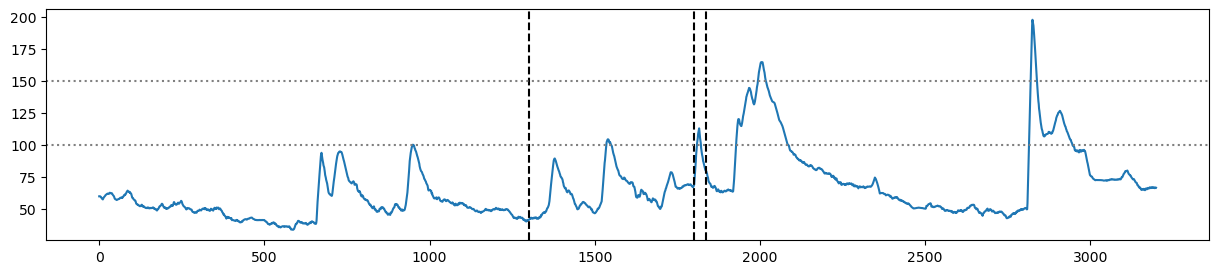

Timestamp('2022-09-20 17:10:00')

In [6]:
# cek datetime
data_cek=data_simulasi.sort_values(by='date',ascending=True).reset_index(drop=True)
a=1800
plt.figure(figsize=(15, 3))
plt.plot(data_cek['height'], '-')
plt.axvline(a-500, color='black', linestyle='--')
plt.axvline(a, color='black', linestyle='--')
plt.axvline(a+36, color='black', linestyle='--')
plt.axhline(100, color='grey', linestyle='dotted')
plt.axhline(150, color='grey', linestyle='dotted')
plt.show()
data_cek.date.loc[a-1]

## Siaga 0 (AMAN)

-----------------------------------------------------------------------------
Datetime            : 2022-09-17 17:10:00
Ketinggian sekarang : 67.17 cm
Status sekarang     : SIAGA 0

Info : [AMAN] Dalam 6 jam kedepan diperkirakan akan tetap berstatus SIAGA 0.
        Tidak akan terjadi banjir.
-----------------------------------------------------------------------------


'Plot Prediksi :'

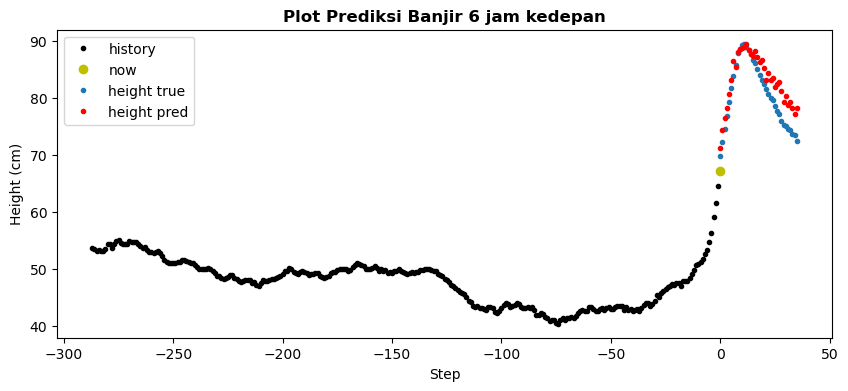

In [7]:
#date_now = input('date: ') 
date_now = '2022-09-17 17:10:00'

# klasifikasi
X_klasifikasi=get_X_klasifikasi(data=data_simulasi, 
                                date=date_now)
y_klasifikasi=klasifikasi_banjir(X=X_klasifikasi,
                                 scaler_X=scaler_X_klasifikasi,
                                 model=model_klasifikasi_banjir)

# prediksi
X_prediksi=get_X_prediksi(data=data_simulasi, 
                          date=date_now)
y_pred=prediksi_banjir(data=data_simulasi,
                       date=date_now,
                       X=X_prediksi,
                       scaler_X=scaler_X_prediksi,
                       scaler_y=scaler_y_prediksi,
                       model=model_prediksi_banjir)
pred_status=klasifikasi_banjir(X=y_pred,
                               scaler_X=scaler_X_klasifikasi,
                               model=model_klasifikasi_banjir)
get_info(y_klasifikasi=y_klasifikasi,
         X=X_prediksi,
         y_pred_status=pred_status)

## Siaga 1 (WASPADA)

-----------------------------------------------------------------------------
Datetime            : 2022-09-20 17:50:00
Ketinggian sekarang : 77.0 cm
Status sekarang     : SIAGA 0

Info : [WASPADA] Dalam 80 menit kedepan diperkirakan akan berstatus SIAGA 1.
        Harap pantau ketinggian air secara berkala.
-----------------------------------------------------------------------------


'Plot Prediksi :'

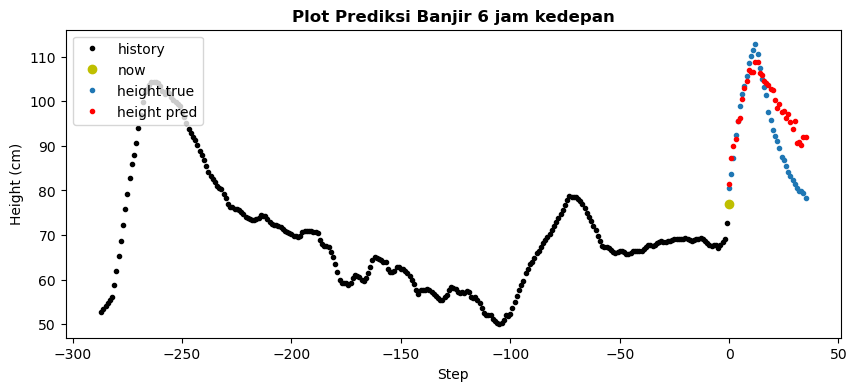

In [8]:
#date_now 
date_now = '2022-09-20 17:50:00'

# klasifikasi
X_klasifikasi=get_X_klasifikasi(data=data_simulasi, 
                                date=date_now)
y_klasifikasi=klasifikasi_banjir(X=X_klasifikasi,
                                 scaler_X=scaler_X_klasifikasi,
                                 model=model_klasifikasi_banjir)

# prediksi
X_prediksi=get_X_prediksi(data=data_simulasi, 
                          date=date_now)
y_pred=prediksi_banjir(data=data_simulasi,
                       date=date_now,
                       X=X_prediksi,
                       scaler_X=scaler_X_prediksi,
                       scaler_y=scaler_y_prediksi,
                       model=model_prediksi_banjir)
pred_status=klasifikasi_banjir(X=y_pred,
                               scaler_X=scaler_X_klasifikasi,
                               model=model_klasifikasi_banjir)
get_info(y_klasifikasi=y_klasifikasi,
         X=X_prediksi,
         y_pred_status=pred_status)

## Siaga 2 (BAHAYA)

-----------------------------------------------------------------------------
Datetime            : 2022-09-27 18:30:00
Ketinggian sekarang : 103.26 cm
Status sekarang     : SIAGA 1

Info : [BAHAYA] Dalam 60 menit kedepan diperkirakan akan berstatus SIAGA 2.
        Berkemungkinan terjadi banjir, segera lakukan evakuasi.
-----------------------------------------------------------------------------


'Plot Prediksi :'

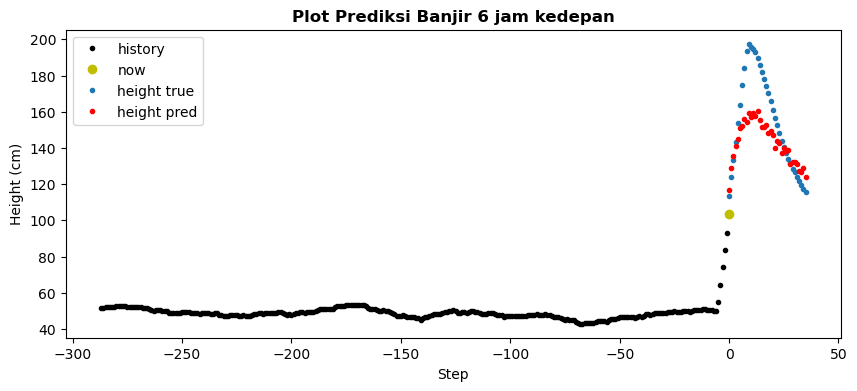

In [9]:
#date_now = input('date: ') 
date_now = '2022-09-27 18:30:00'

# klasifikasi
X_klasifikasi=get_X_klasifikasi(data=data_simulasi, 
                                date=date_now)
y_klasifikasi=klasifikasi_banjir(X=X_klasifikasi,
                                 scaler_X=scaler_X_klasifikasi,
                                 model=model_klasifikasi_banjir)

# prediksi
X_prediksi=get_X_prediksi(data=data_simulasi, 
                          date=date_now)
y_pred=prediksi_banjir(data=data_simulasi,
                       date=date_now,
                       X=X_prediksi,
                       scaler_X=scaler_X_prediksi,
                       scaler_y=scaler_y_prediksi,
                       model=model_prediksi_banjir)
pred_status=klasifikasi_banjir(X=y_pred,
                               scaler_X=scaler_X_klasifikasi,
                               model=model_klasifikasi_banjir)
get_info(y_klasifikasi=y_klasifikasi,
         X=X_prediksi,
         y_pred_status=pred_status)

## Evaluasi

### model klasifikasi

In [10]:
# data simulasi
df=data_simulasi[['height']].copy()
# define aman=0, siaga 1=1, siaga 2=2
df['status'] = np.where(df['height'] <= 100, 0, 
                        np.where(df['height'] <= 150, 1, 
                                 2))
# Membagi fitur dan label
X = df[['height']]
y = df[['status']]

# scaling
scaler_X = scaler_X_klasifikasi
X_scaled = scaler_X.transform(X)

In [11]:
y.value_counts()

status
0         2882
1          276
2           42
dtype: int64

In [12]:
# Evaluasi model
simulasi_scores = model_klasifikasi_banjir.evaluate(X_scaled, y, verbose=0)

# dataframe untuk evaluasi model
df_eval = pd.DataFrame(index=['simulasi'],
                       columns=['loss', 'accuracy'])

df_eval.loc['simulasi', 'loss']=simulasi_scores[0]
df_eval.loc['simulasi', 'accuracy']=simulasi_scores[1]

df_eval

,loss,accuracy
simulasi,0.02344,0.996875


### model prediksi

In [13]:
df=data_simulasi.copy()

In [14]:
df['cloudcover_3h'] = df['cloudcover'].shift(18)
df['humidity_18h'] = df['humidity'].shift(108)
df['height_diff_18h'] = df['height'] - df['height'].shift(108)
df = df.dropna().reset_index(drop = True)

# Membagi fitur/prediktor dan label 
X = df[['height','windgust','cloudcover_3h','humidity_18h','height_diff_18h']]
y = df[['height']]

In [15]:
# X
scaler_X = scaler_X_prediksi
X_scaled = scaler_X.transform(X)

# y
scaler_y = scaler_y_prediksi
y_scaled = scaler_y.transform(y)

# reshape 
y_scaled = y_scaled.reshape(-1)

In [16]:
# fungsi window
def create_window(data, window_size, future_size, label):
    X_window = []
    y_window = []

    for i in range(len(data) - window_size - future_size):
        X_window.append(data[i:i+window_size])
        y_window.append(label[i+window_size:i+window_size+future_size])

    return np.array(X_window), np.array(y_window)

In [17]:
# window (3)
window_size_3 = 288
future_size_3 = 36

X_window_3, y_window_3 = create_window(X_scaled, window_size_3, future_size_3, y_scaled)

print(X_window_3.shape, y_window_3.shape)

(2768, 288, 5) (2768, 36)


In [18]:
def eval_df(model, X_window, y_window):
    # Evaluasi model 
    y_results = model.evaluate(X_window, y_window)

    # train MAE, MSE, RMSE
    mae, mse, rmse = y_results[1], y_results[0], y_results[2]

    # Membuat dataframe untuk hasil evaluasi
    evaluation_results = pd.DataFrame({'MAE': [mae],
                                       'MSE': [mse],
                                       'RMSE': [rmse]},
                                      index=['Simulasi'])
    # Menampilkan dataframe
    return evaluation_results.round(4)

In [19]:
# menampilkan hasil evaluasi model
eval_df(model_prediksi_banjir, X_window_3, y_window_3)

87/87 [==============================] - 7s 64ms/step - loss: 0.0032 - mean_absolute_error: 0.0347 - root_mean_squared_error: 0.0566


,MAE,MSE,RMSE
Simulasi,0.0347,0.0032,0.0566


## ... save data (pickle)

In [20]:
# read data and format date
data_simulasi = pd.read_csv('dataset/dataset_saved-A/dataset_A2/flood-A2_simulasi-sorted.csv')
data_simulasi['date'] = data_simulasi['date'] + ':00'
data_simulasi['date'] = pd.to_datetime(data_simulasi['date'], format='%d/%m/%Y %H:%M:%S')
# rename columns
data_simulasi = data_simulasi.rename(columns = {'date':'datetime', 
                                                'height':'height (cm)', 
                                                'temp':'temp (C)', 
                                                'feelslike':'feelslike (C)', 
                                                'dew':'dew (C)', 
                                                'humidity':'humidity (%)', 
                                                'precip':'precip (mm)',
                                                'precipprob':'precipprob (%)', 
                                                'windgust':'windgust (kph)', 
                                                'windspeed':'windspeed (kph)', 
                                                'winddir':'winddir (degree)', 
                                                'sealevelpressure':'sealevelpressure (mbar)',
                                                'cloudcover':'cloudcover (%)', 
                                                'visibility':'visibility (km)'})
data_simulasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   datetime                 3200 non-null   datetime64[ns]
 1   height (cm)              3200 non-null   float64       
 2   temp (C)                 3200 non-null   float64       
 3   feelslike (C)            3200 non-null   float64       
 4   dew (C)                  3200 non-null   float64       
 5   humidity (%)             3200 non-null   float64       
 6   precip (mm)              3200 non-null   float64       
 7   precipprob (%)           3200 non-null   int64         
 8   windgust (kph)           3200 non-null   float64       
 9   windspeed (kph)          3200 non-null   float64       
 10  winddir (degree)         3200 non-null   float64       
 11  sealevelpressure (mbar)  3200 non-null   int64         
 12  cloudcover (%)           3200 non-

In [24]:
import pickle

# Menyimpan objek menggunakan pickle
with open("flood-simulasi.pkl", 'wb') as file:
    pickle.dump(data_simulasi, file)

In [25]:
# Membuka file menggunakan pickle
with open("flood-simulasi.pkl", 'rb') as file:
    loaded_data = pickle.load(file)

In [26]:
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   datetime                 3200 non-null   datetime64[ns]
 1   height (cm)              3200 non-null   float64       
 2   temp (C)                 3200 non-null   float64       
 3   feelslike (C)            3200 non-null   float64       
 4   dew (C)                  3200 non-null   float64       
 5   humidity (%)             3200 non-null   float64       
 6   precip (mm)              3200 non-null   float64       
 7   precipprob (%)           3200 non-null   int64         
 8   windgust (kph)           3200 non-null   float64       
 9   windspeed (kph)          3200 non-null   float64       
 10  winddir (degree)         3200 non-null   float64       
 11  sealevelpressure (mbar)  3200 non-null   int64         
 12  cloudcover (%)           3200 non-

---